### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eda_helper_functions
import os
from sklearn.ensemble import IsolationForest

### Reading the Training Data

In [2]:
PATH_DIR = r'D:\Ml projects\car dekho\flights practice\data'

In [3]:
def read_data(file):
    file_name = f'{file}.csv'
    path = os.path.join(PATH_DIR,file_name)
    return pd.read_csv(path)

In [4]:
train = read_data('train')
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087


In [5]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [6]:
train = train.assign(**{
    col:pd.to_datetime(train.loc[:,col],format='mixed')
    for col in ['date_of_journey','dep_time','arrival_time']
}).dropna()
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,2024-06-27 08:55:00,2024-06-27 19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,2024-06-27 17:30:00,2024-06-27 04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,2024-06-27 11:40:00,2024-06-27 14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,2024-06-27 09:25:00,2024-06-27 18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,2024-06-27 22:55:00,2024-06-27 07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-27 10:45:00,2024-06-27 18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,2024-06-27 09:25:00,2024-06-27 18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,2024-06-27 14:00:00,2024-06-27 19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,2024-06-27 07:55:00,2024-06-27 13:25:00,330,1.0,No Info,6152


### High Level Summary of the Data

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6694 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6694 non-null   object        
 1   date_of_journey  6694 non-null   datetime64[ns]
 2   source           6694 non-null   object        
 3   destination      6694 non-null   object        
 4   dep_time         6694 non-null   datetime64[ns]
 5   arrival_time     6694 non-null   datetime64[ns]
 6   duration         6694 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6694 non-null   object        
 9   price            6694 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 575.3+ KB


In [8]:
train.describe(include='number')

,duration,total_stops,price
count,6694.000000,6694.000000,6694.000000
mean,633.371676,0.801464,9031.197341
std,502.951999,0.659737,4639.830703
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,920.000000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [9]:
(
    train.assign(total_stops = 
        train.total_stops.astype(object)
        
    )
    .describe(include = 'O')
)

,airline,source,destination,total_stops,additional_info
count,6694,6694,6694,6694.0,6694
unique,9,5,6,4.0,7
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2391,2729,2729,3580.0,5248


### High Level Analysis Of missing Values

In [10]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


### High Level Analysis of Outlier

In [11]:
forest = IsolationForest(n_estimators=20, random_state=42)

In [12]:
(
    train
    .assign(outlier = forest.fit_predict(train
                                         .drop(columns='price')
                                         .select_dtypes(include = 'number'))
    )
    .query('outlier == -1')
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
5,Jet Airways,2019-04-21,Banglore,Delhi,2024-06-27 18:55:00,2024-06-27 22:00:00,185,0.0,In-flight meal not included,4544,-1
7,Spicejet,2019-06-15,Mumbai,Hyderabad,2024-06-27 05:45:00,2024-06-27 07:15:00,90,0.0,No check-in baggage included,2647,-1
9,Jet Airways,2019-05-09,Delhi,Cochin,2024-06-27 23:05:00,2024-06-27 04:25:00,1760,2.0,No Info,15129,-1
10,Jet Airways,2019-06-12,Kolkata,Banglore,2024-06-27 14:05:00,2024-06-27 10:05:00,1200,1.0,No Info,13044,-1
12,Jet Airways,2019-06-24,Delhi,Cochin,2024-06-27 21:25:00,2024-06-27 19:00:00,1295,2.0,No Info,13292,-1
...,...,...,...,...,...,...,...,...,...,...,...
6687,Air India,2019-06-06,Kolkata,Banglore,2024-06-27 05:50:00,2024-06-27 08:55:00,1625,2.0,No Info,12723,-1
6688,Jet Airways,2019-06-15,Delhi,Cochin,2024-06-27 21:25:00,2024-06-27 12:35:00,910,2.0,In-flight meal not included,9905,-1
6689,Indigo,2019-03-03,Mumbai,Hyderabad,2024-06-27 09:10:00,2024-06-27 10:40:00,90,0.0,No Info,5755,-1
6690,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-27 10:45:00,2024-06-27 18:50:00,1925,2.0,No Info,11093,-1


### Pair Plots

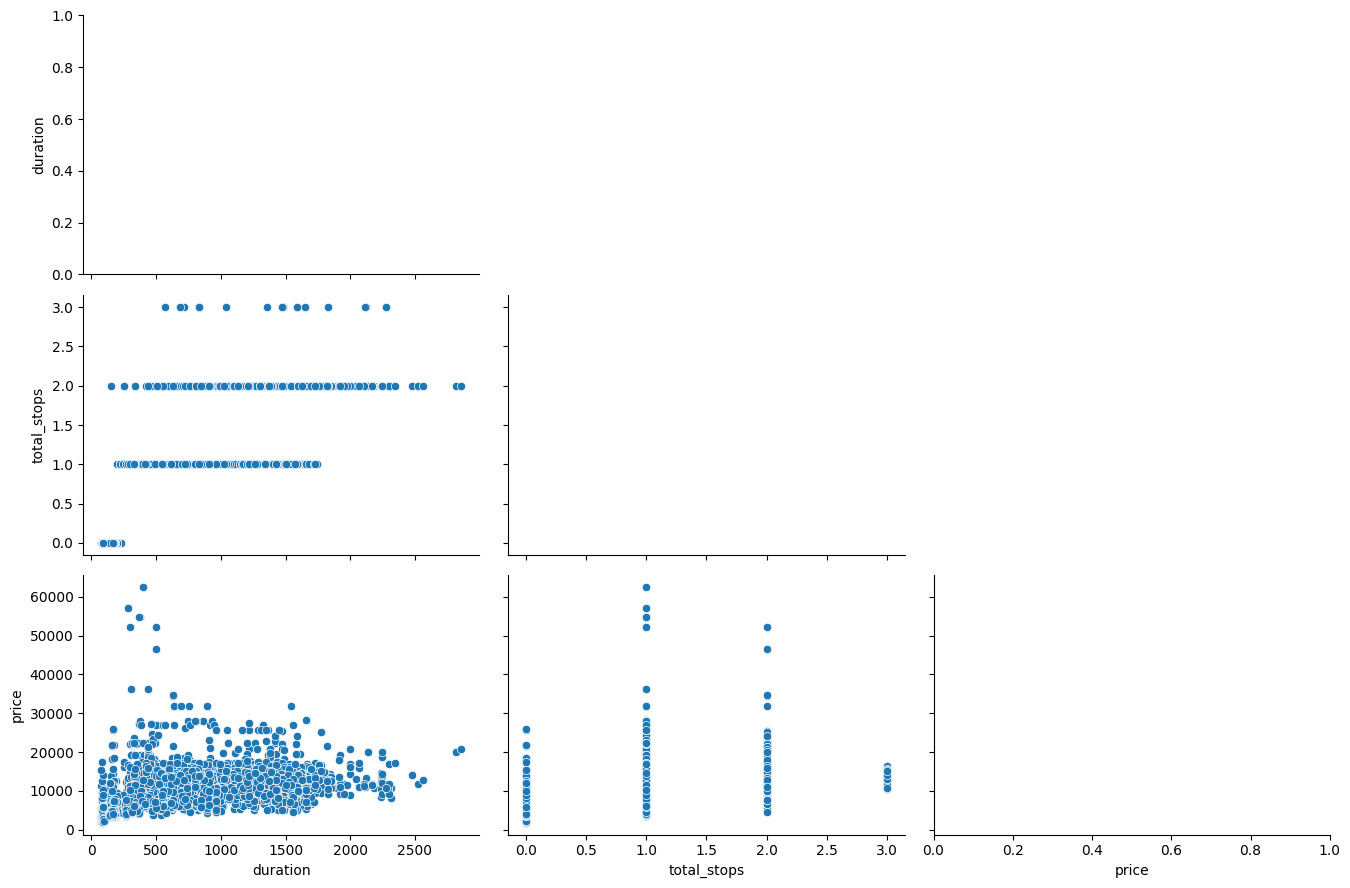

In [13]:
eda_helper_functions.pair_plots(train)

### Correaltion Analysis

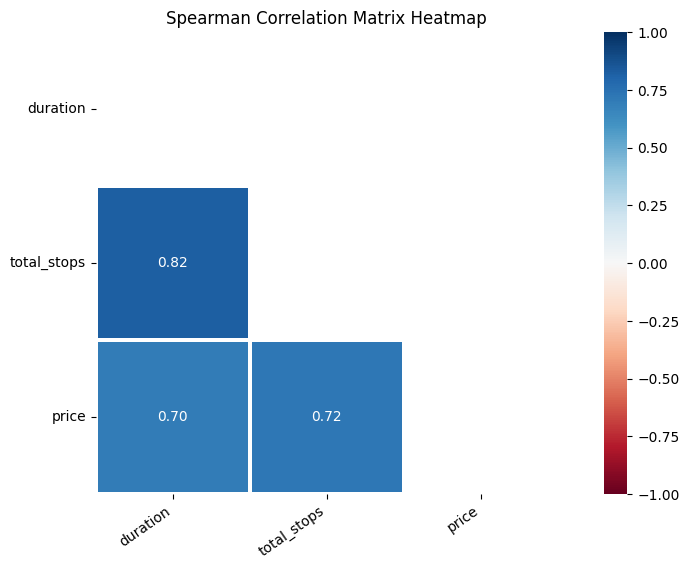

In [14]:
eda_helper_functions.correlation_heatmap(train)

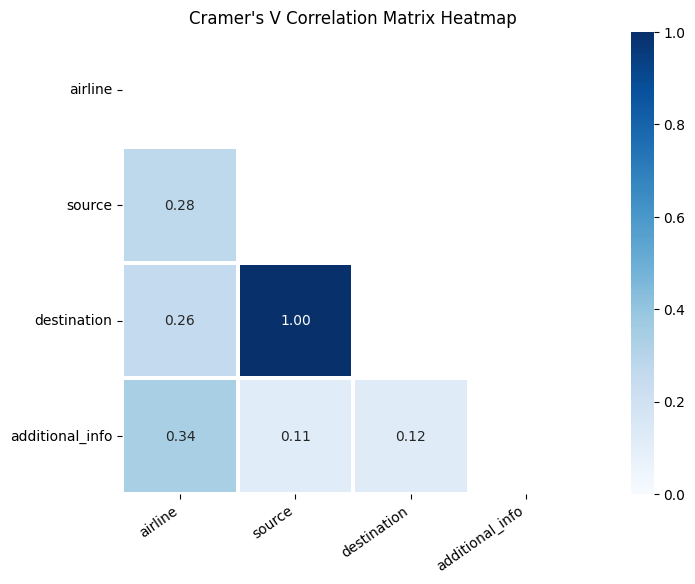

In [15]:
eda_helper_functions.cramersV_heatmap(train)

### Detailed Analysis

### Airline

In [16]:
eda_helper_functions.cat_summary(train,'airline')

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,9
top,Jet Airways
freq,2391


,count,percentage
category,,
Jet Airways,2391,0.357186
Indigo,1296,0.193606
Air India,1075,0.160592
Multiple Carriers,736,0.109949
Spicejet,537,0.080221
Vistara,322,0.048103
Air Asia,211,0.031521
Goair,125,0.018673
Trujet,1,0.000149


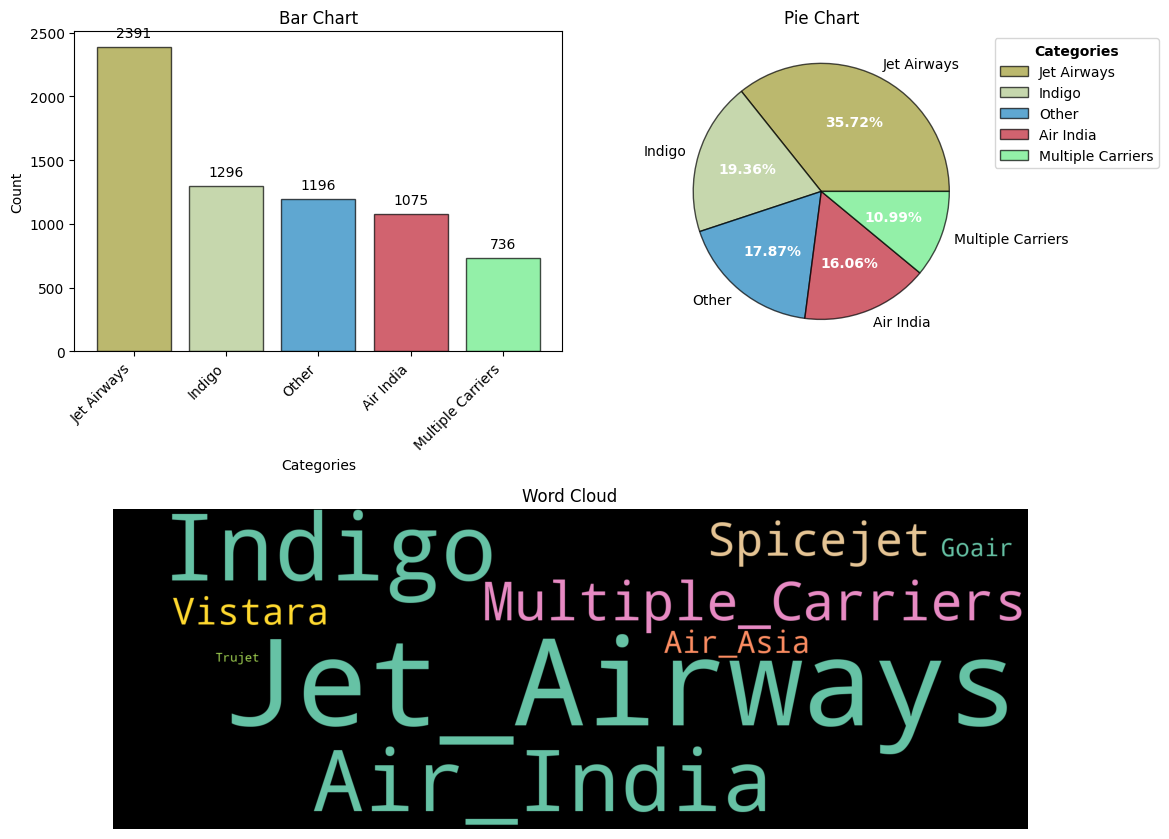

In [17]:
eda_helper_functions.cat_univar_plots(train,'airline',k=4)

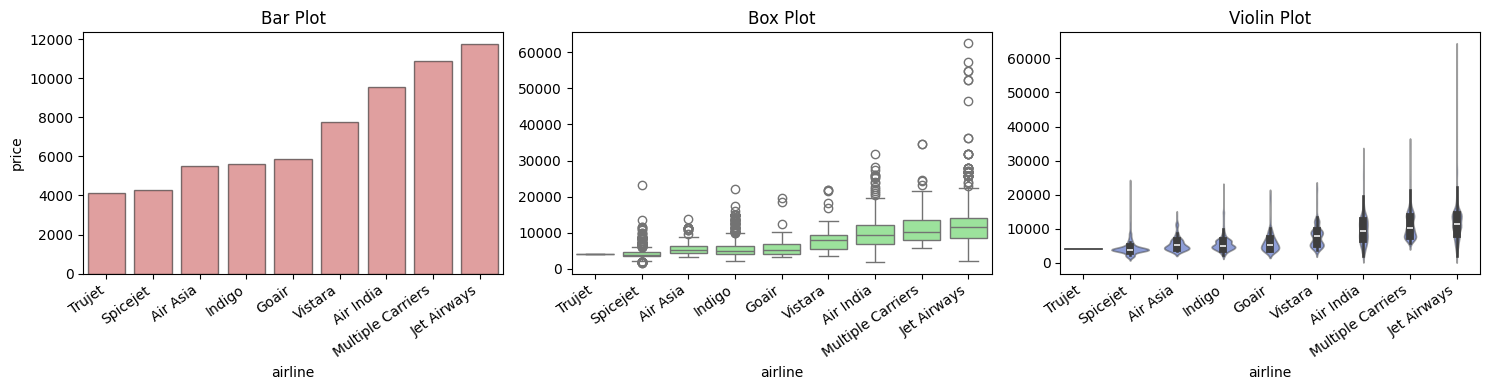

In [18]:
eda_helper_functions.num_cat_bivar_plots(train,
                                        num_var='price',
                                        cat_var='airline')

In [19]:
eda_helper_functions.num_cat_hyp_testing(train,
                                        'price',
                                        'airline')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 473.2504388077414
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3130.947388921903
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


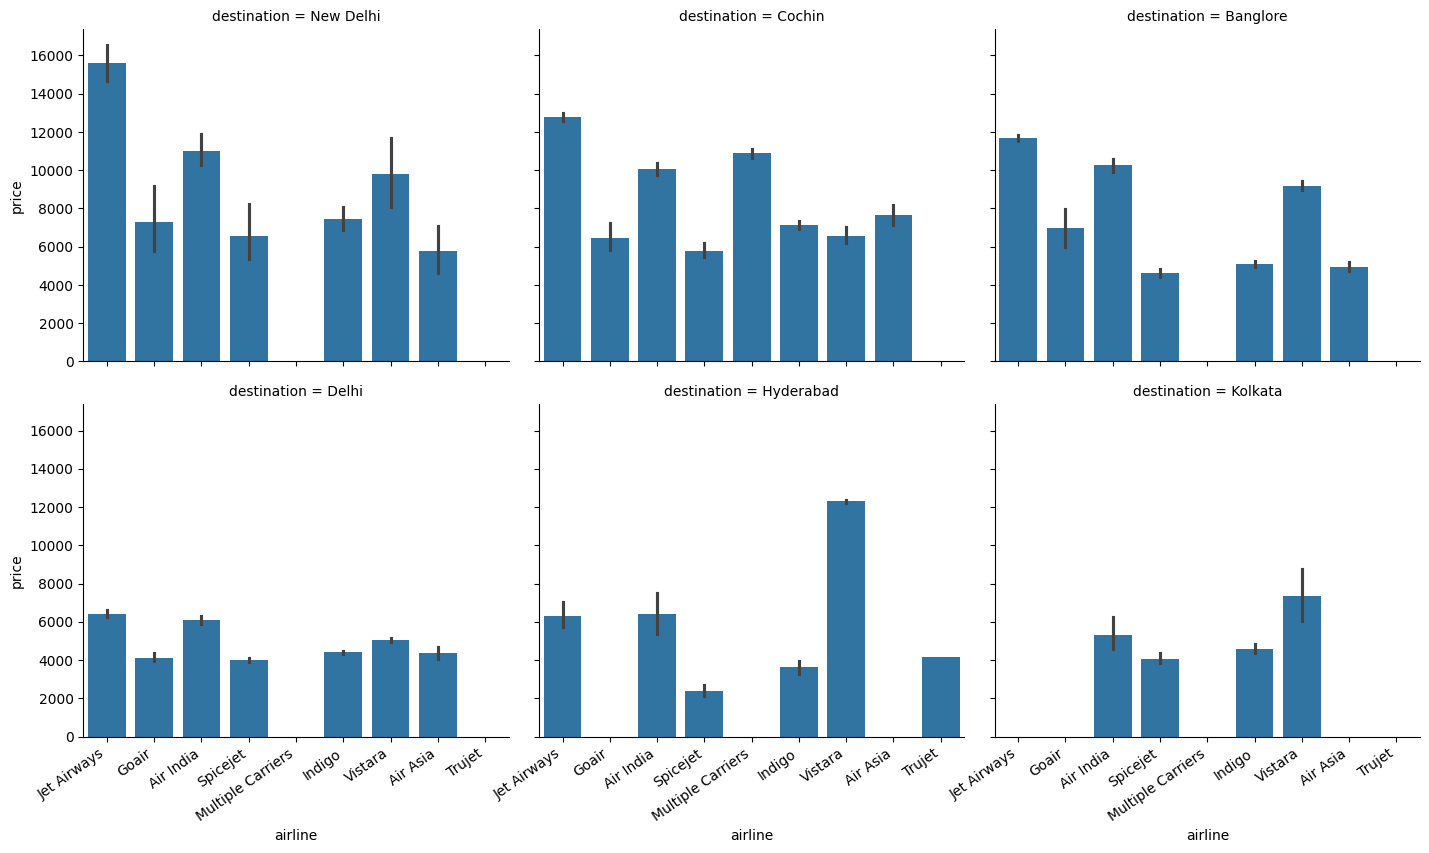

In [20]:
airline_grid = sns.FacetGrid(
    data=train,
    col = 'destination',
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey=True   
)
airline_grid.map(sns.barplot,'airline','price',order = train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

### date_of_journey

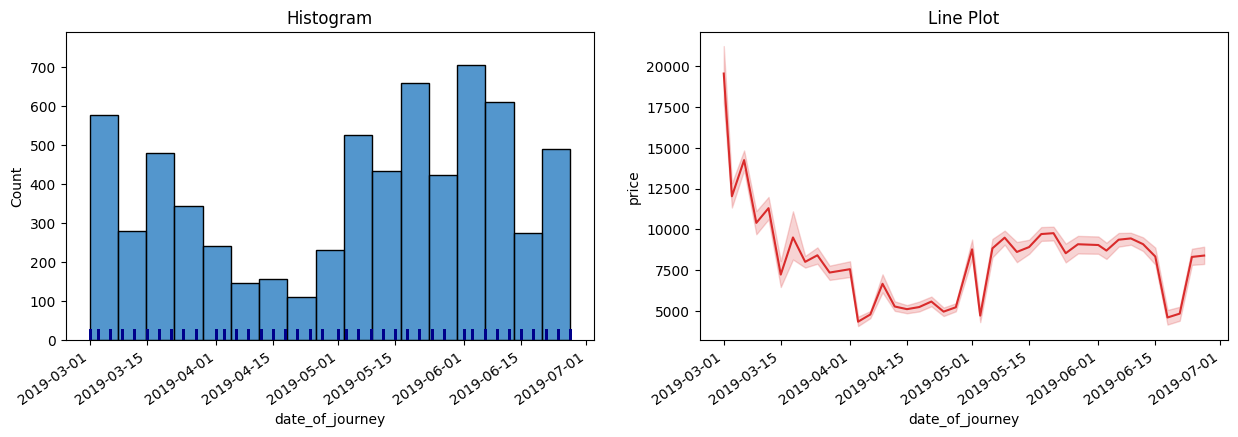

In [21]:
eda_helper_functions.dt_univar_plots(train,
                                    'date_of_journey',
                                    'price')

<Axes: xlabel='Month'>

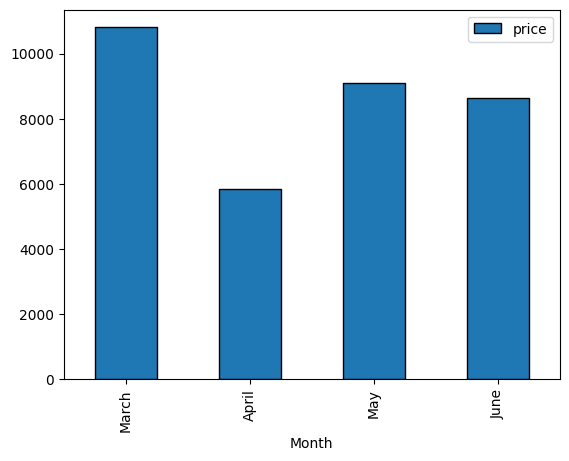

In [22]:
(
    train
    .groupby(pd.Grouper(key = 'date_of_journey',freq='M'))
    .price
    .mean()
    .to_frame()
    .set_axis(['March','April','May','June'],axis=0)
    .rename_axis(index = ['Month'])
    .plot(
        kind = 'bar',
        edgecolor = 'black'
    )
)

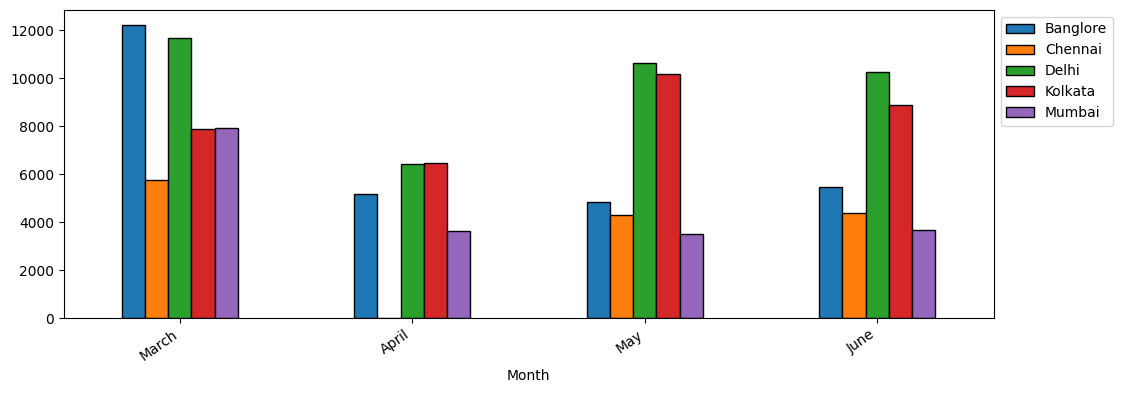

In [23]:
(
    train
    .groupby([pd.Grouper(key='date_of_journey',freq='M'),'source',])
    .price
    .mean()
    .unstack()
    .set_axis(['March','April','May','June'],axis=0)
    .rename_axis(index = ['Month'])
    .plot(
        kind = 'bar',
        figsize=(12,4),
        edgecolor = 'black'
    )
)
ax = plt.gca()
ax.legend(
    loc = 'upper left',
    bbox_to_anchor=(1,1)
)
eda_helper_functions.rotate_xlabels(ax)

### dep_time

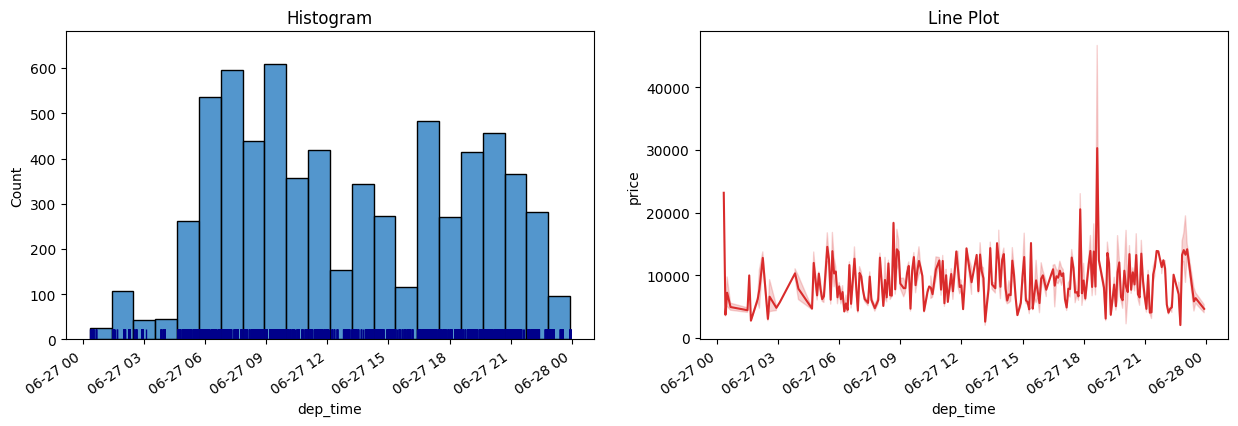

In [24]:
eda_helper_functions.dt_univar_plots(train,'dep_time','price')

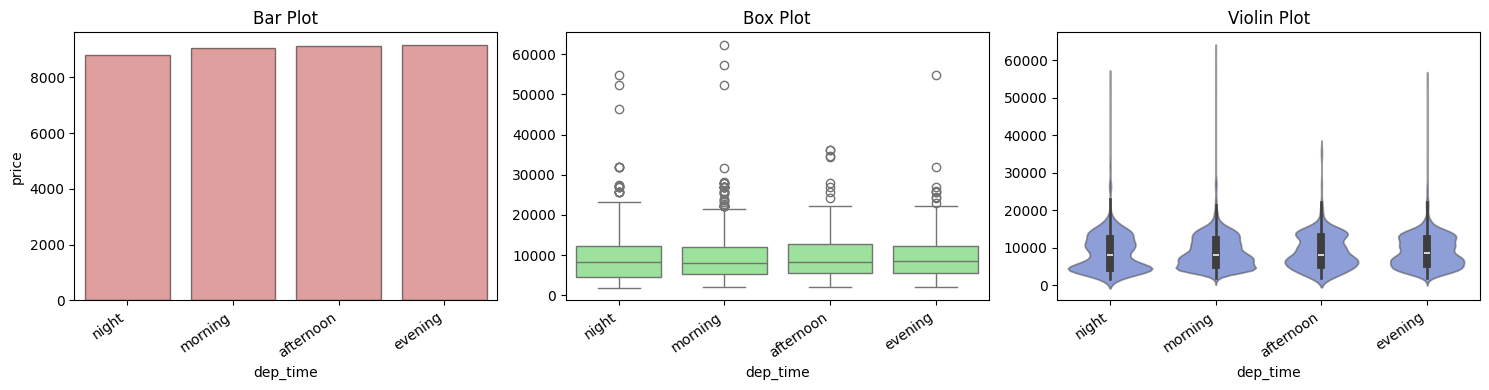

In [25]:
(
    train
    .assign(dep_time = lambda ser:(
        np.select([ser.dep_time.dt.hour.between(4,12,inclusive = 'left'),
                                ser.dep_time.dt.hour.between(12,16,inclusive = 'left'),
                                ser.dep_time.dt.hour.between(16,20,inclusive = 'left')],
                                ['morning','afternoon','evening'],
                                default = 'night'
    )))
    .pipe(eda_helper_functions.num_cat_bivar_plots,'price','dep_time')
)

### duration

In [26]:
eda_helper_functions.num_summary(train,'duration')

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,510.00
75,920.00
90,1440.00
95,1601.75
99,1855.00


,value
mean,633.371676
trimmed mean (5%),599.575174
trimmed mean (10%),570.895258
median,510.000000


,value
var,252960.712875
std,502.951999
IQR,750.000000
mad,340.000000
coef_variance,0.794087


,value
skewness,0.894131
kurtosis,-0.052204


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 7.367044778597017e-57
Test Statistic       : 0.886539636636061
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 248.45769626661695
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


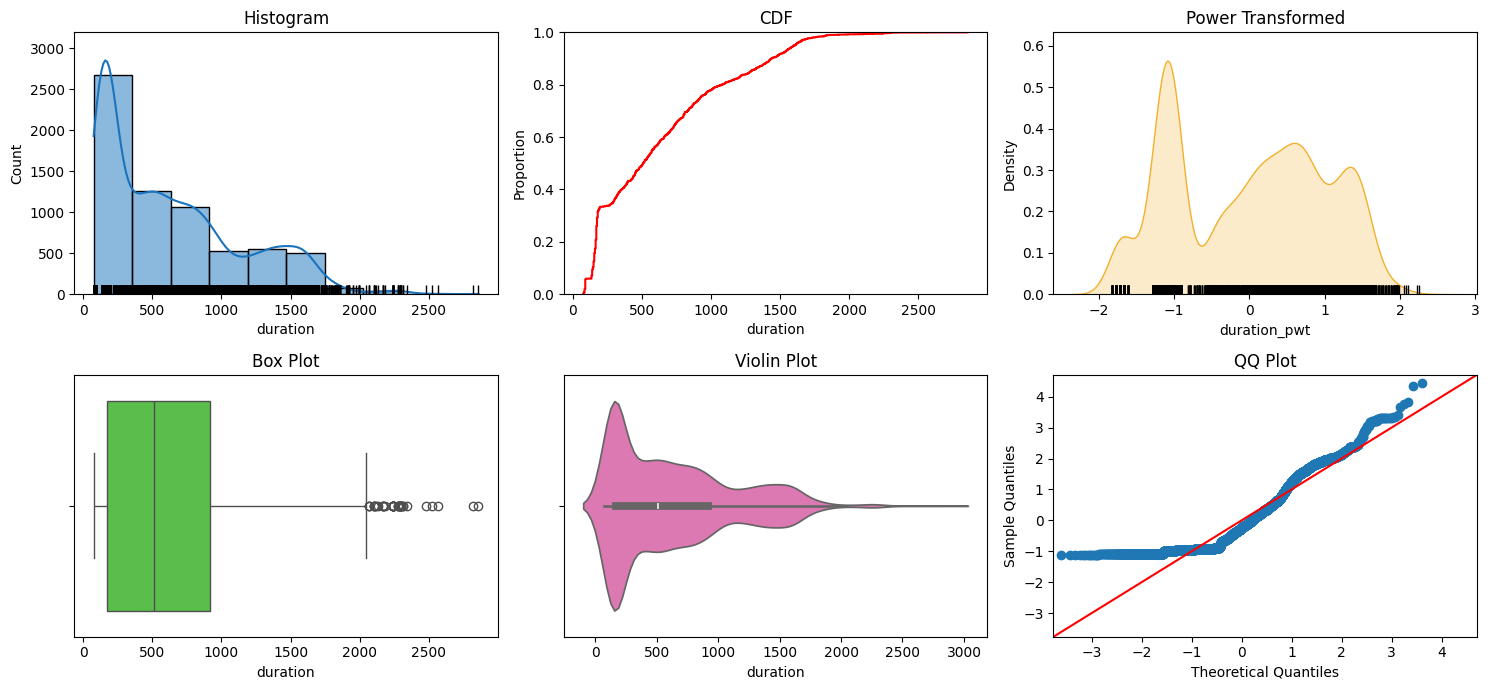

In [27]:
eda_helper_functions.num_univar_plots(train,'duration')

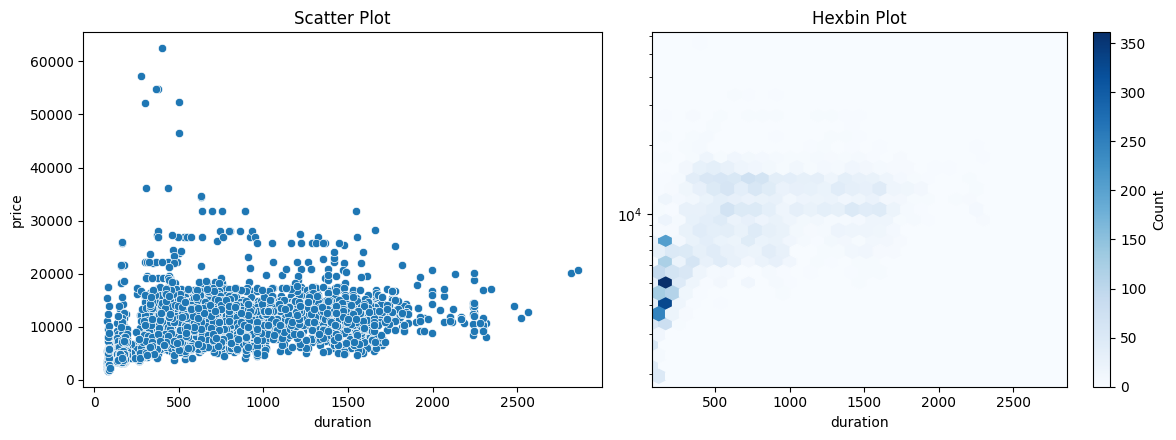

In [28]:
eda_helper_functions.num_bivar_plots(
    train,
    'duration',
    'price',
    hexbin_kwargs=dict(
        yscale='log',
        gridsize=30,
        cmap='Blues'
    )
)

In [29]:
eda_helper_functions.num_num_hyp_testing(train,'price','duration')

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5091878071906594
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6980000420004595
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


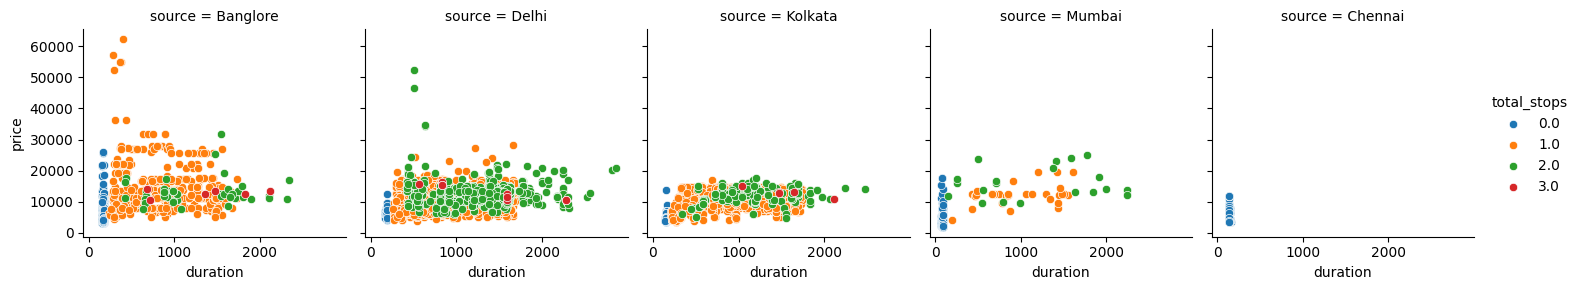

In [30]:
duration_grid = sns.FacetGrid(
    data = train,
    col='source',
    hue='total_stops',
    sharey=True
)
duration_grid.map(sns.scatterplot,'duration','price')
duration_grid.add_legend()

In [31]:
eda_helper_functions.get_iqr_outliers(train,'duration')

Lower Limit : -955.0
Upper Limit : 2045.0


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3690,Air India,2019-05-01,Kolkata,Banglore,2024-06-27 05:50:00,2024-06-27 16:15:00,2065,2.0,No Info,10991
6079,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-27 17:55:00,2024-06-27 04:25:00,2070,2.0,No Info,17072
3225,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-27 17:55:00,2024-06-27 04:25:00,2070,2.0,In-flight meal not included,15812
2990,Air India,2019-03-03,Banglore,New Delhi,2024-06-27 11:05:00,2024-06-27 22:10:00,2105,2.0,No Info,11791
4589,Air India,2019-03-18,Banglore,New Delhi,2024-06-27 11:05:00,2024-06-27 22:10:00,2105,2.0,No Info,11161
1517,Air India,2019-03-03,Banglore,New Delhi,2024-06-27 11:05:00,2024-06-27 22:10:00,2105,2.0,No Info,11948
2916,Air India,2019-05-12,Kolkata,Banglore,2024-06-27 12:00:00,2024-06-27 23:15:00,2115,3.0,No Info,10991
2170,Air India,2019-03-12,Banglore,New Delhi,2024-06-27 06:45:00,2024-06-27 18:05:00,2120,3.0,No Info,13387
1105,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-27 16:50:00,2024-06-27 04:25:00,2135,2.0,No Info,19907
4000,Air India,2019-03-06,Delhi,Cochin,2024-06-27 07:05:00,2024-06-27 19:15:00,2170,2.0,No Info,11552


In [32]:
eda_helper_functions.cat_summary(train,'additional_info')

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,7
top,No Info
freq,5248


,count,percentage
category,,
No Info,5248,0.783986
In-flight meal not included,1215,0.181506
No check-in baggage included,207,0.030923
1 Long layover,16,0.002390
Change airports,5,0.000747
Business class,2,0.000299
Red-eye flight,1,0.000149
